In [1]:
import json
import os
import random

from sklearn.cluster import KMeans
from sklearn.decomposition import IncrementalPCA
from sklearn.preprocessing import normalize, MinMaxScaler
import IPython.display as ipd
import librosa
import librosa.display
import matplotlib.cm as plt_cm
import matplotlib.colors as plt_colors
import matplotlib.pyplot as plt
import numpy as np
import scipy
import soundfile as sf

import utils.audio

In [2]:
random.seed(1337)
random_state = 451
np.random.seed(42)

In [3]:
# Constants
SILENCE_CLASS = 1
SILENCE_ID = 1

# Variables
args = {
    'audio_file_path': '../../projects/tomomibot/material/tomomi-original-6.wav',
    'experiment_name': 'mono-sequence-original-6',
    
    'block_len_sec': 120, # Read audio file in blocks of x seconds
    'trim_top_db': 5,     # dB threshold for trimming audio slices

    'n_components': 2,    # Number of PCA components
    'n_clusters': 1000,   # Number of KMeans clusters

    'kernel_size': 25,    # Average volume kernel size

    'ms_per_step': 20,    # Sample timestep size
    'rms_thresh':  0.01,  # RMS threshold to consider sound events as silence
}

In [4]:
# Read audio data
info = sf.info(args['audio_file_path'])
y_len = info.frames
sr = info.samplerate
blocksize = sr * args['block_len_sec']
block_num = y_len // blocksize

block_gen = sf.blocks(args['audio_file_path'],
                      blocksize=blocksize,
                      always_2d=True,
                      dtype='float32')

print(info)
print('')

print('Start reading {} blocks ...'.format(block_num + 1))

data = []
id_counter = 2 # id = 1 is for our silence class
for block_no, bl in enumerate(block_gen):
    offset = blocksize * block_no
    
    # Downmix to mono
    y = np.mean(bl, axis=1)
    
    # Detect onsets
    onsets = utils.audio.detect_onsets(y, sr=sr)
    
    # Slice audio into parts, analyze mffcs and save them
    slices = utils.audio.slice_audio(y, onsets, offset=offset, top_db=args['trim_top_db'])
    for i in range(len(slices) - 1):
        y_slice = slices[i][0]
        
        # Calculate MFCCs
        mfcc = utils.audio.mfcc_features(y_slice, sr)
        
        # RMS Volume
        rms = librosa.feature.rms(y=y_slice)
        
        # Keep all information stored
        data.append({'id': id_counter,
                     'mfcc': mfcc.tolist(),
                     'rms': np.max(rms),
                     'start': np.uint32(slices[i][1]).item(),
                     'end': np.uint32(slices[i][2]).item()})
        
        id_counter += 1
        
    print('Reading block {0} ({1:.0f}%) w. {2} slices'.format(block_no + 1,
                                                              block_no / block_num * 100,
                                                              len(slices)))
    
print('Finished reading {} events ...'.format(id_counter - 2))

../../projects/tomomibot/material/tomomi-original-6.wav
samplerate: 44100 Hz
channels: 1
duration: 1e+01:35.868 min
format: WAV (Microsoft) [WAV]
subtype: Signed 16 bit PCM [PCM_16]

Start reading 6 blocks ...
Reading block 1 (0%) w. 325 slices
Reading block 2 (20%) w. 389 slices
Reading block 3 (40%) w. 397 slices
Reading block 4 (60%) w. 371 slices
Reading block 5 (80%) w. 346 slices
Reading block 6 (100%) w. 90 slices
Finished reading 1912 events ...


In [5]:
# Get PCA of file
melfccs = [x['mfcc'] for x in data]
pca, _, _, variance = utils.audio.pca(melfccs, args['n_components'])

print('PCA variance = {}'.format(variance * 100))

PCA variance = [32.3 60.3]


In [6]:
# K-means clustering
kmeans = KMeans(n_clusters=args['n_clusters'],
                random_state=random_state).fit(pca)

sequence_classes = kmeans.predict(pca)

In [7]:
# .. & cluster the K-means clusters :-)
# to find out which ones are similar ..

n_kmeans_clusters = min(args['n_clusters'], 20) # .. we have 20 colors (see 'tab20')

kmeans_kmeans = KMeans(n_clusters=n_kmeans_clusters,
                       random_state=random_state).fit(kmeans.cluster_centers_)

cluster_classes = kmeans_kmeans.predict(kmeans.cluster_centers_)

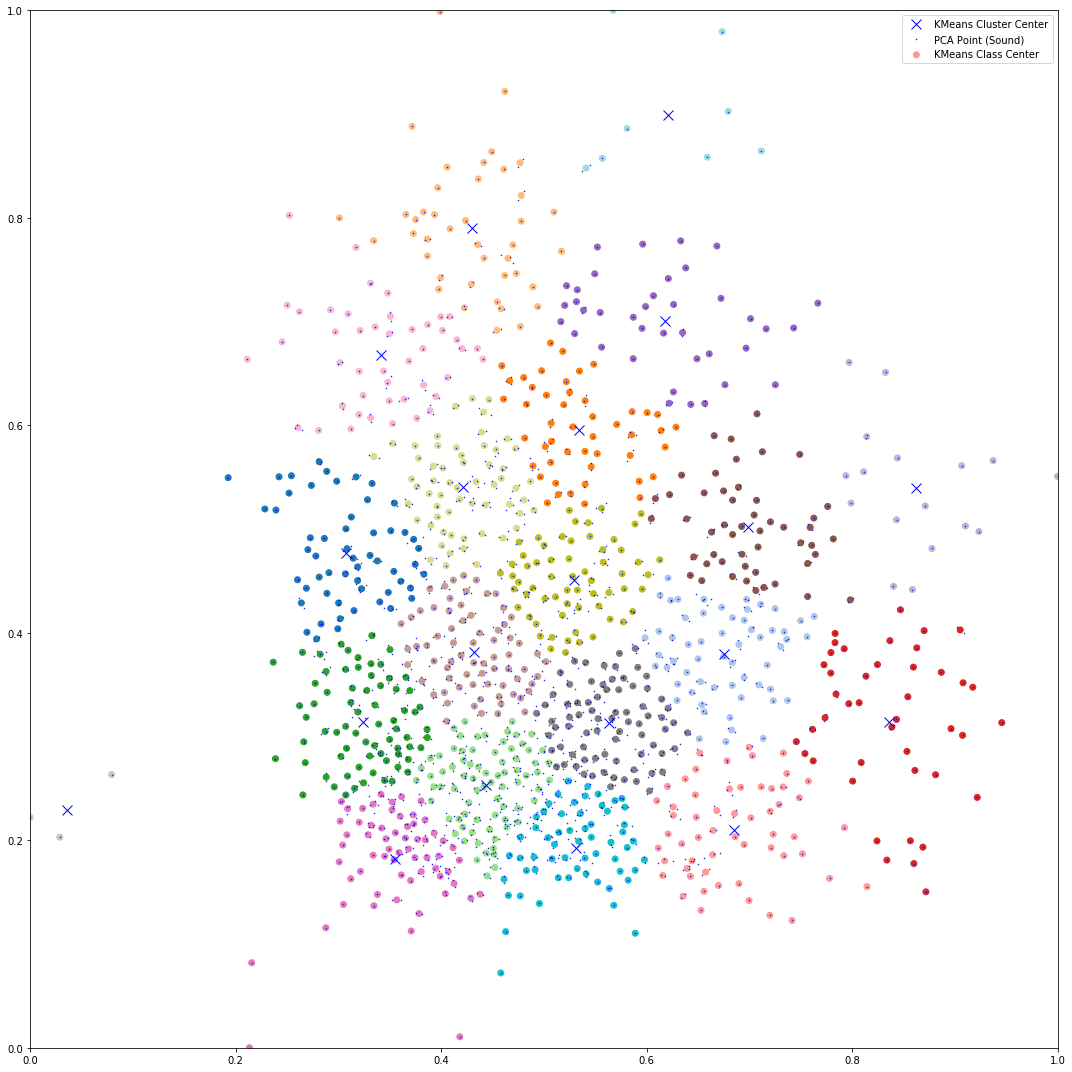

In [8]:
# ~~~~~~~~~~~~~~~~~~~~~~~~~
# Prepare colormap

cmap = plt.get_cmap('tab20') 
cnorm  = plt_colors.Normalize(vmin=0, vmax=n_kmeans_clusters - 1)
scalar_map = plt_cm.ScalarMappable(norm=cnorm, cmap=cmap)

# ~~~~~~~~~~~~~~~~~~~~~~~~~
# Plot clusters, centers and samples

centers = kmeans.cluster_centers_
cluster_centers = kmeans_kmeans.cluster_centers_

# ~~~~~~~~~~~~~~~~~~~~~~~~~

fig_clusters, ax = plt.subplots(figsize=(15, 15))

ax.axis([0.0, 1.0, 0.0, 1.0])

class_colors = [scalar_map.to_rgba(c) for c in cluster_classes]

ax.scatter(centers[:,0], centers[:,1], c=class_colors, label='KMeans Class Center')
ax.plot(cluster_centers[:,0], cluster_centers[:,1], 'bx', label='KMeans Cluster Center', markersize=10)
ax.plot(pca[:,0], pca[:,1], 'bo', label='PCA Point (Sound)', markersize=0.5)

ax.legend()

plt.tight_layout()

mean = 1.912, min = 1, max = 7
classes > mean = 515, classes < mean = 485, ratio = 1.1


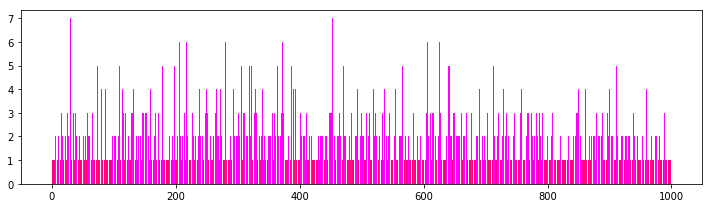

In [9]:
# Print some information about the class distribution
points_per_class = []
for group in range(args['n_clusters']):
    points_per_class.append(
        len(np.where(sequence_classes == group)[0]))

mean = np.mean(points_per_class)
maxv = np.max(points_per_class)

print('mean = {}, min = {}, max = {}'.format(mean,
                                             np.min(points_per_class),
                                             maxv))

strong_classes = len(np.where(points_per_class > mean)[0])
weak_classes = len(np.where(points_per_class < mean)[0])

print('classes > mean = {0}, classes < mean = {1}, ratio = {2:.2}'.format(
    strong_classes,
    weak_classes,
    strong_classes / weak_classes))

# ~~~~~~~~~~~~~~~~~~~~~~~~~

# Plot classes and class sizes to visualize distribution

bar_colors = [(1, 0, min(p / mean, 1)) for p in points_per_class]
fig_classes = plt.figure(figsize=(10, 3))
plt.bar(np.arange(args['n_clusters']), points_per_class, color=bar_colors)

# ~~~~~~~~~~~~~~~~~~~~~~~~~

# Finalize plot

plt.tight_layout()

In [10]:
# Calculate average volume
rms_data = [x['rms'] for x in data]
rms_data = rms_data / np.max(rms_data)
kernel = np.array(np.full((args['kernel_size'],), 1)) / args['kernel_size']
rms_avg_data = np.convolve(rms_data, kernel, 'same')
rms_avg_data = rms_avg_data / np.max(rms_avg_data)

In [11]:
# Add class and volume to our data
for i, item in enumerate(data):
    data[i]['rms'] = np.float32(rms_data[i]).item()
    data[i]['rms_avg'] = np.float32(rms_avg_data[i]).item()
    
    # +1 to class for giving silence its own class 1
    data[i]['class'] = np.uint32(sequence_classes[i] + 1).item()

In [12]:
data[0]

{'class': 516,
 'end': 38400,
 'id': 2,
 'mfcc': [-6.067075450309103,
  0.9560496237608546,
  0.7145423936535679,
  0.4546338186198973,
  0.22011800424580583,
  0.01733830729310691,
  -0.09795200769283423,
  -0.07411427910877466,
  0.03294578476750291,
  0.10870983582537058,
  0.11790552377151262,
  0.11052204125373528,
  0.10831114125191096,
  0.1284620917321579,
  0.12834810098405058,
  0.1301536753776745,
  0.12893646774929524,
  0.1274523407493741,
  0.12948229638610034,
  0.1327366691066571,
  0.13275397194196403,
  0.1305779058405841,
  0.13033026903862996,
  0.131705282163809,
  0.13131385486587774,
  0.129791901049269,
  0.12062569677975045,
  0.11777255619605628,
  0.12281806246714738,
  0.12851949975595162,
  0.13355827887398833,
  0.13741101770702205,
  0.13918890818551763,
  0.1382306678129296,
  0.1355821807589101,
  0.13341755123320537,
  0.13277812531353828,
  0.1329509023278839,
  0.13316698827010356],
 'rms': 0.30328837037086487,
 'rms_avg': 0.31103673577308655,
 'star

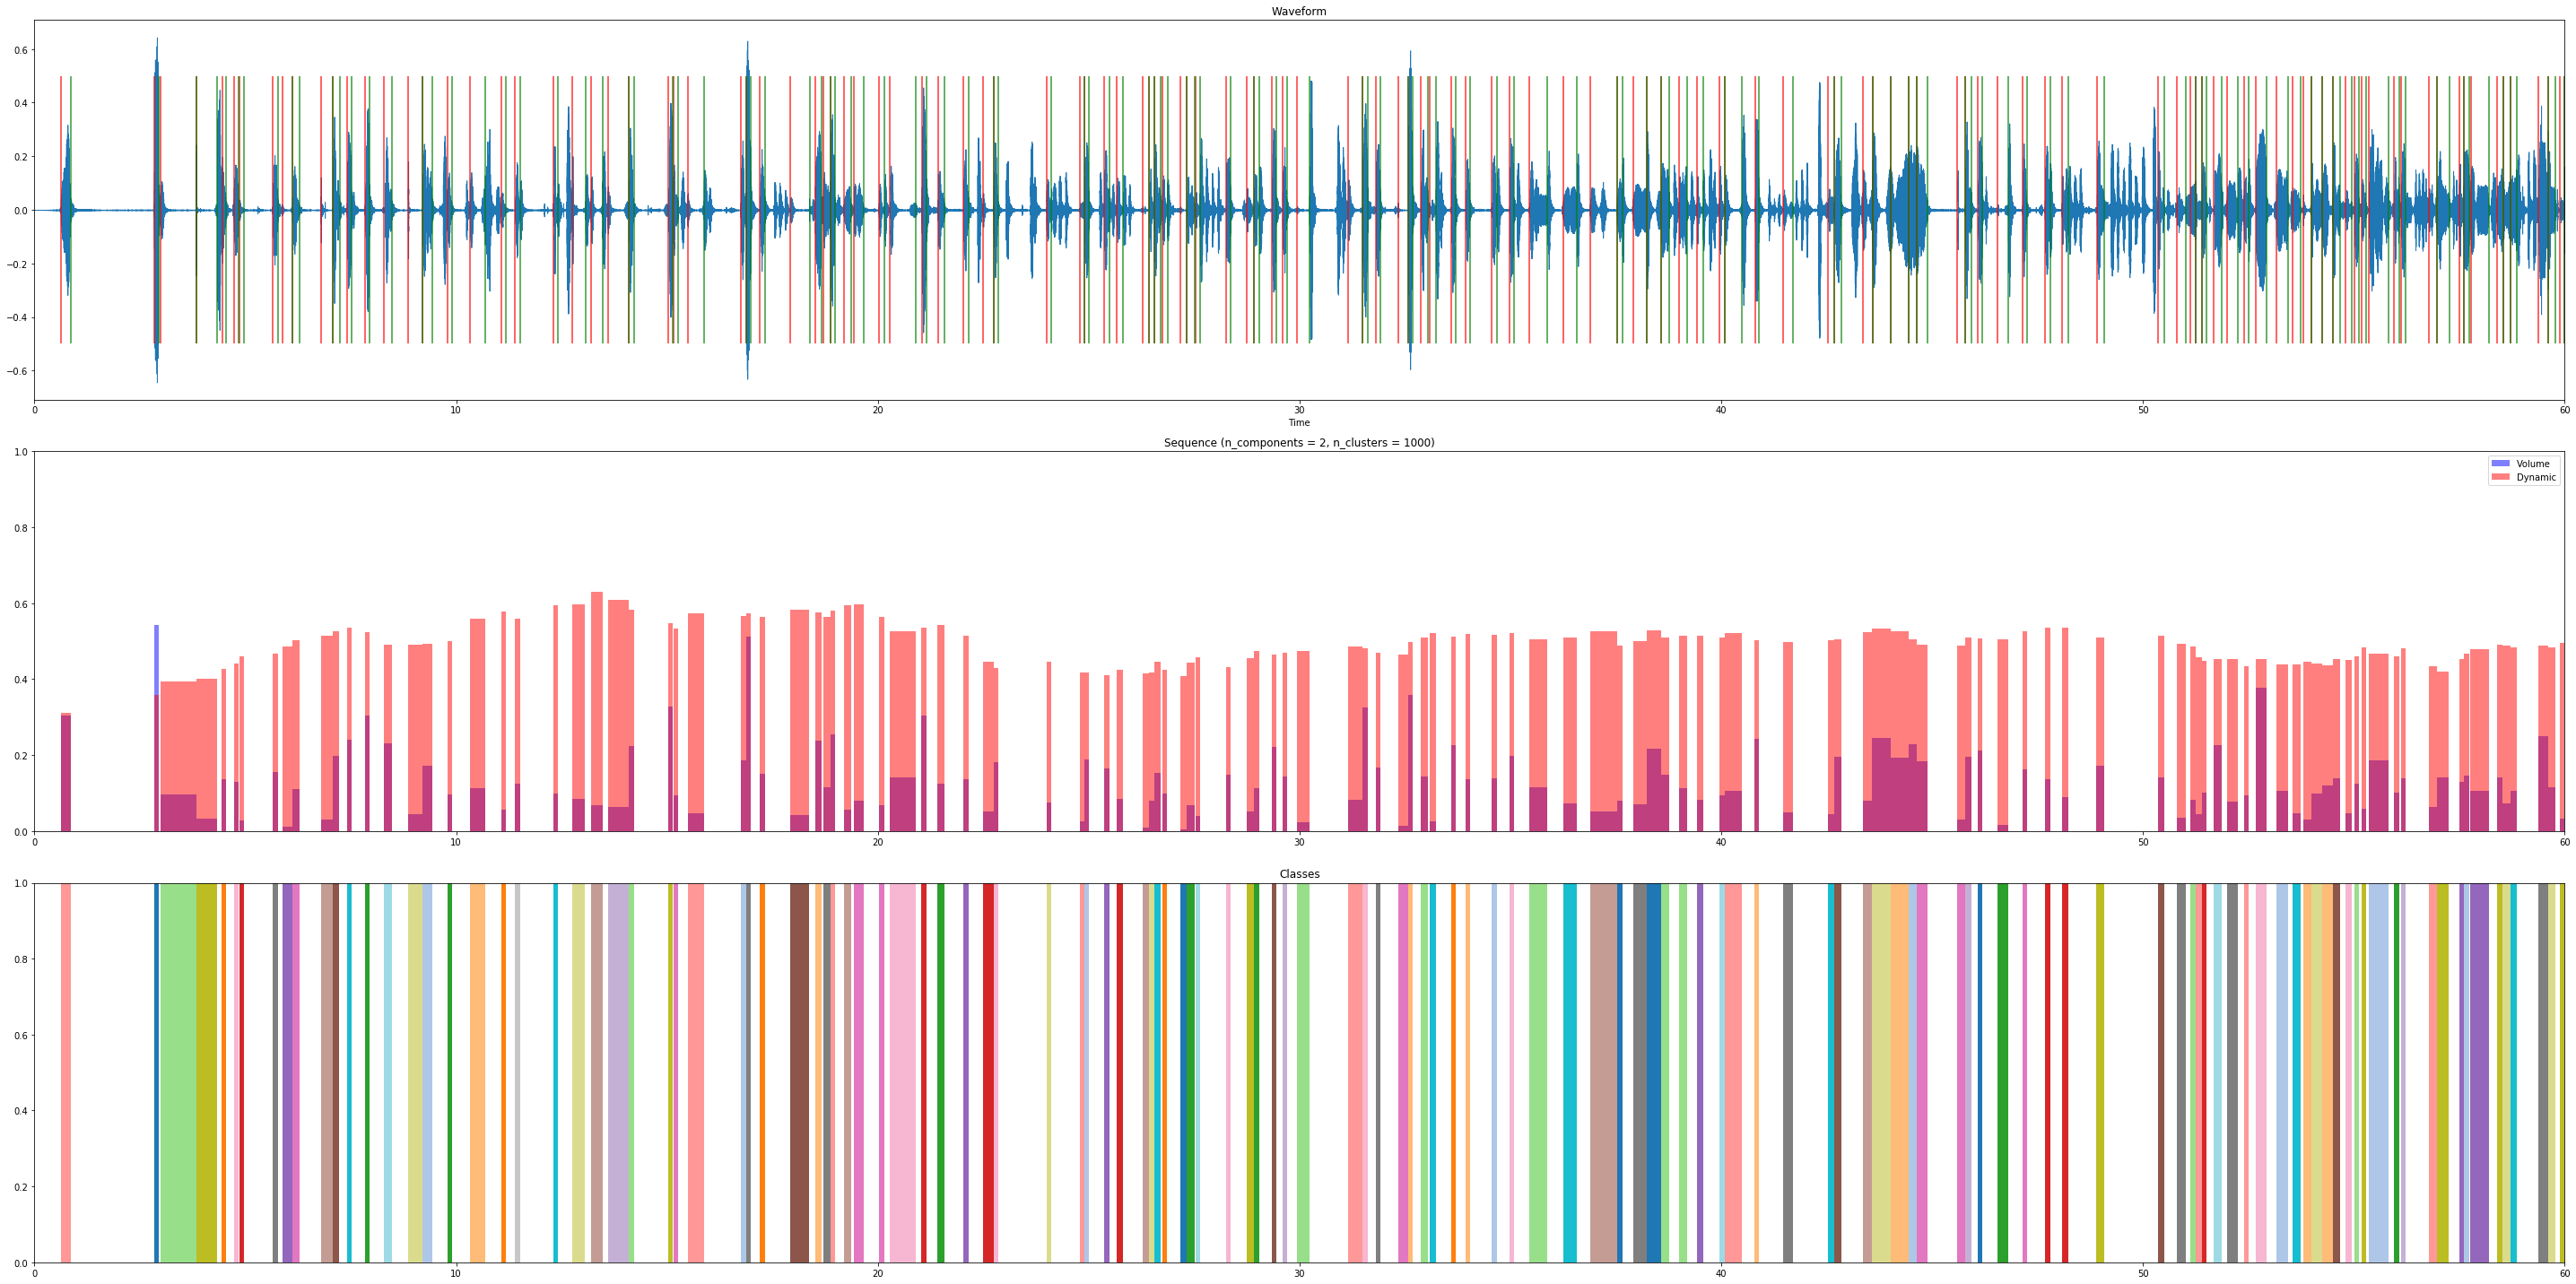

In [13]:
data_slice = 60

# Convert start and end frames
c_starts = np.array([x['start'] for x in data]) / sr
c_ends = np.array([x['end'] for x in data]) / sr
c_width = c_ends - c_starts

# ~~~~~~~~~~~~~~~~~~~~~~~~~

# Start plot
fig_sequence = plt.figure(figsize=(40, 20))

# 1. Audio waveform
# ~~~~~~~~~~~~~~~~~~~~~~~~~

# Load full audio file
y, _ = librosa.load(args['audio_file_path'], sr=sr, duration=data_slice)

# Plot waveform
plt.subplot(3, 1, 1, title="Waveform")
librosa.display.waveplot(y[:data_slice*sr], sr=sr)

# Plot onsets
plt.vlines(c_starts, -0.5, 0.5,
           color='r',
           alpha=0.8)

plt.vlines(c_ends, -0.5, 0.5,
           color='g',
           alpha=0.8)

# 2. Plot sequence
# ~~~~~~~~~~~~~~~~~~~~~~~~~

# Plot sequence
plt.subplot(3, 1, 2, title="Sequence (n_components = {}, n_clusters = {})".format(
    args['n_components'], args['n_clusters']))

plt.axis([0, data_slice, 0, 1])

plt.bar(c_starts, [x['rms'] for x in data],
        width=c_width,
        align='edge',
        color='blue',
        alpha=0.5,
        label='Volume')

plt.bar(c_starts, [x['rms_avg'] for x in data],
        width=c_width,
        align='edge',
        color='red',
        alpha=0.5,
        label='Dynamic')

plt.legend(frameon=True)

# 3. Class
# ~~~~~~~~~~~~~~~~~~~~~~~~~

plt.subplot(3, 1, 3, title="Classes")

plt.axis([0, data_slice, 0, 1])

# Color them to indicate similarity between classes
bar_color = [scalar_map.to_rgba(c) for c in cluster_classes]

plt.bar(c_starts, 1,
        width=c_width,
        align='edge',
        color=bar_color,
        label='Class')

# ~~~~~~~~~~~~~~~~~~~~~~~~~

# Finalize plot
plt.tight_layout()

In [14]:
# Make a table of data points by id
data_table = {}
for item in data:
    item_converted = item.copy()
    
    # Convert long integers (64bit) to strings
    item_converted['start'] = str(item_converted['start'])
    item_converted['end'] = str(item_converted['end'])
    
    data_table[item_converted['id']] = item_converted
    
# Add "silence" data class to dataset
silence_data = {
    'id': SILENCE_ID,
    'class': SILENCE_CLASS,
}

data_table[SILENCE_ID] = silence_data

# Generate a sequence with timesteps
steps = []
current_data_index = 0
events_counter = 0

for step_index, step_start in enumerate(range(0, y_len, args['ms_per_step'])):
    step_end = step_start + args['ms_per_step']
    if step_end > y_len:
        break
    
    # Find a sound event or silence during that timestep
    found_data_id = SILENCE_ID
    while True:
        if current_data_index > len(data) - 1:
            break
            
        sound_start = data[current_data_index]['start']
        sound_end = data[current_data_index]['end']
        sound_id = data[current_data_index]['id']
        
        if not (sound_end <= step_start or sound_start >= step_end):
            # Sound is within timestep
            found_data_id = sound_id
            break
        elif step_start >= sound_start and step_end <= sound_end:
            # Sound overlaps timestap
            found_data_id = sound_id
            break
        elif sound_start >= step_end:
            # Sound is past timestep .. could not find anything
            break
        else:
            # Keep on searching!
            current_data_index += 1
            
    # Check if sound event has low volume, convert it to silence then
    if found_data_id != SILENCE_ID and data_table[found_data_id]['rms'] < args['rms_thresh']:
        found_data_id = SILENCE_ID
        
    if found_data_id != SILENCE_ID:
        events_counter += 1
    
    # Add timestep to our list
    step = {
        'id': step_index,
        'start': step_start,
        'end': step_end,
        'event_id': found_data_id,
    }
    
    steps.append(step)

# Combine events and steps into one dataset
dataset = {
    'args': args,
    'events': data_table,
    'steps': steps,
}

print('Generated {} timesteps with {} events'.format(len(steps), events_counter))

Generated 1402089 timesteps with 875498 events


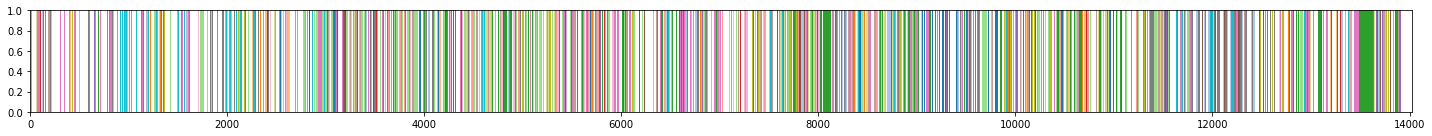

In [15]:
step_plot_every = 100 # Only print every nth step

# ~~~~~~~~~~~~~~~~~~~~~~~~~

# Prepare steps to plot
step_slice = []
for step_index in range(0, len(steps), step_plot_every):
    step_slice.append(steps[step_index])

# ~~~~~~~~~~~~~~~~~~~~~~~~~    

# Prepare plot

fig_steps = plt.figure(figsize=(20, 2))

plt.axis([0, len(step_slice), 0, 1])

# ~~~~~~~~~~~~~~~~~~~~~~~~~

# Colorcode timesteps with clustered classes, use white for silence
bar_color = [(1, 1, 1, 1) if s['event_id'] is SILENCE_ID else scalar_map.to_rgba(
    cluster_classes[data_table[s['event_id']]['class'] - 1]
) for s in step_slice]

# Plot all timesteps
plt.bar(range(len(step_slice)), 1,
        width=1,
        align='edge',
        color=bar_color,
        label='Timestep Classes')

# ~~~~~~~~~~~~~~~~~~~~~~~~~

# Finalize plot

plt.tight_layout()

In [16]:
dataset_name = '{}.json'.format(args['experiment_name'])
dataset_path = os.path.join(os.getcwd(), 'files', 'mono-experiment', dataset_name)

# Save dataset as .json file
with open(dataset_path, 'w') as file:
    json.dump(dataset, file, indent=2, separators=(',', ': '))

In [17]:
def save_figure(fig, name):
    fig_base_name = '{}cls-{}pca-{}db-{}ms'.format(args['n_clusters'],
                                                   args['n_components'],
                                                   args['trim_top_db'],
                                                   args['ms_per_step'])
    fig_name = '{}-plot-{}-{}.png'.format(args['experiment_name'], fig_base_name, name)
    fig_path = os.path.join(os.getcwd(), 'files', 'mono-experiment', fig_name)
    
    fig.savefig(fig_path, bbox_inches='tight')
    
# Save plots for validation
save_figure(fig_clusters, 'clusters')
save_figure(fig_classes, 'classes')
save_figure(fig_sequence, 'sequence')
save_figure(fig_steps, 'steps')

print('Done!')

Done!
